In [184]:
import torch
import torch.nn.functional as F
import json
import math
import multiprocessing
import queue
from matplotlib import pyplot as plt

from Simulation import Simulation
from LanderSteeringModel import LanderSteeringModel
from SteeringModelActorCritic import LanderSteeringModelActor, LanderSteeringModelCritic

In [185]:
def load_settings():
    with open("settings.json") as file:
        settings = json.load(file)
    return settings

In [186]:
settings = load_settings()
tower_arm_settings = settings["terrain"]["tower"]["towerArm"]
target_catch_pin_position_x = (tower_arm_settings["xMax"] + tower_arm_settings["xMin"]) / 2
target_catch_pin_position_y = tower_arm_settings["yMax"] + settings["lander"]["catchPin"]["radius"]
target_catch_pin_position = (target_catch_pin_position_x, target_catch_pin_position_y)
target_angle = 0
target_velocity = (0, 0)
target_angular_velocity = 0


def loss_function_components(telemetry):
    catch_pin_position = telemetry['catch_pin_position']
    angle = telemetry['angle']
    velocity = telemetry['velocity']
    angular_velocity = telemetry['angular_velocity']

    position_loss = math.sqrt((catch_pin_position[0] - target_catch_pin_position[0])**2 + (catch_pin_position[1] - target_catch_pin_position[1])**2)
    angle_loss = abs(angle - target_angle)
    velocity_loss = math.sqrt((velocity[0] - target_velocity[0])**2 + (velocity[1] - target_velocity[1])**2)
    angular_velocity_loss = abs(angular_velocity - target_angular_velocity)

    position_loss = min(math.exp(min(position_loss, 25) / 10) - 1 + position_loss / 2, 100) + position_loss / 10
    angle_loss = min(angle_loss * 100 + math.exp(angle_loss) - 1, 100) + angle_loss * 10
    velocity_loss = min(math.exp(min(velocity_loss, 5) / 2.5) -1 + velocity_loss, 100) + velocity_loss / 10
    angular_velocity_loss = min(angular_velocity_loss * 100 + math.exp(angular_velocity_loss) - 1, 100) + angular_velocity_loss * 10
    loss = position_loss + angle_loss + velocity_loss + angular_velocity_loss
    return torch.tensor([loss, position_loss, angle_loss, velocity_loss, angular_velocity_loss])

def loss_function(telemetry):
    return loss_function_components(telemetry)[0]

In [187]:
lander_initial_position = settings["landerInitialPosition"]["x"], settings["landerInitialPosition"]["y"]
simulation_iterations_per_step = settings["simulationIterationsPerStep"]
simulation_steps_per_second = settings["simulationStepsPerSecond"]

In [188]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [189]:
lander_steering_actor = LanderSteeringModelActor(device, target_catch_pin_position).to(device)
lander_steering_critic = LanderSteeringModelCritic(device, target_catch_pin_position).to(device)

learning_rate = 1e-5 * 10
actor_optimizer = torch.optim.Adam(lander_steering_actor.parameters(), lr=learning_rate)
critic_optimizer = torch.optim.Adam(lander_steering_critic.parameters(), lr=learning_rate)

In [190]:
lander_initial_position = (150, 300)
lander_initial_angle = 0
lander_initial_position_deviation = (50, 100)
lander_initial_angle_deviation = math.pi / 6

future_reward_discount_factor = 0.99

rewards = []
losses = []

episodes = 1000
simulation_duration = 20
print("Episode\t\tSteps\t\tLoss\t\tReward\t\tAvg last 10 rewards\t\tAvg last 10 losses")
for episode in range(episodes):
    lander_initial_position_x = lander_initial_position[0] + (torch.rand(1).item() - 0.5) * 2 * lander_initial_position_deviation[0]
    lander_initial_position_y = lander_initial_position[1] + (torch.rand(1).item() - 0.5) * 2 * lander_initial_position_deviation[1]
    lander_initial = lander_initial_position_x, lander_initial_position_y
    initial_angle = lander_initial_angle + (torch.rand(1).item() - 0.5) * 2 * lander_initial_angle_deviation
    
    simulation = Simulation(settings, lander_initial, simulation_iterations_per_step, lander_initial_angle=initial_angle)

    state = simulation.get_telemetry()
    initial_loss = loss_function(state).to(device)
    total_reward = 0
    running = True

    max_steps = simulation_duration * simulation_steps_per_second
    step_count = 0
    loss = initial_loss
    while running:
        step_count += 1
        result, next_state = simulation.step(1 / simulation_steps_per_second)
        next_loss = loss_function(next_state).to(device)
        reward = loss - next_loss

        action = lander_steering_actor(state)
        binary_steering = LanderSteeringModel.to_binary_steering(LanderSteeringModel.output_to_steering_input(action))
        simulation.set_steering_input(binary_steering)

        value = lander_steering_critic(state)
        next_value = lander_steering_critic(next_state)

        target = reward + future_reward_discount_factor * next_value
        advantage = target - value

        # Update Critic
        critic_loss = advantage.pow(2)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Update Actor
        actor_loss = -((action ** 2).mean() * advantage.detach())
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        state = next_state
        loss = next_loss
        total_reward = initial_loss - loss

        if result is not None or step_count > max_steps:
            running = False


    rewards.append(total_reward.item())
    last_10_rewards = rewards[-10:] if len(rewards) > 10 else rewards
    last_10_average = sum(last_10_rewards) / len(last_10_rewards)
    losses.append(loss.item())
    last_10_losses = losses[-10:] if len(losses) > 10 else losses
    last_10_losses_average = sum(last_10_losses) / len(last_10_losses)
    print(f"\r{episode + 1}/{episodes}\t\t{step_count}\t\t{loss.item():.2f}\t\t{total_reward:.2f}\t\t{last_10_average:.2f}\t\t{last_10_losses_average:.2f}", end="")
    if (episode + 1) % 10 == 0:
        print()

    if (episode + 1) % 200 == 0:
        torch.save(lander_steering_actor.state_dict(), "model.pth")


torch.save(lander_steering_actor.state_dict(), "model.pth")


Episode		Steps		Loss		Reward		Avg last 10 rewards		Avg last 10 losses


10/1000		149		96.52		43.44		-71.48		232.68810
20/1000		325		401.25		-248.11		-188.19		340.70
30/1000		175		276.78		-133.56		-128.67		285.93
40/1000		194		345.61		-182.96		-180.43		334.03
50/1000		225		296.99		-138.86		-222.92		383.54
60/1000		373		447.83		-275.55		-237.16		391.71
70/1000		386		492.73		-354.41		-293.93		453.23
80/1000		245		469.36		-327.76		-297.48		450.51
90/1000		204		428.79		-248.70		-278.92		437.16
100/1000		392		541.05		-403.26		-286.93		441.09
110/1000		381		416.10		-292.39		-310.89		465.37
120/1000		297		573.37		-445.10		-294.39		453.28
130/1000		271		539.08		-379.08		-281.18		445.16
140/1000		208		432.01		-276.85		-250.06		410.71
150/1000		176		280.66		-158.73		-189.82		339.71
160/1000		244		472.57		-330.55		-231.61		395.05
170/1000		230		424.55		-254.89		-214.81		371.10
180/1000		193		401.07		-258.72		-177.60		336.25
190/1000		226		351.12		-199.23		-183.02		330.20
200/1000		221		469.66		-298.67		-203.76		358.81
210/1000		136		359.48		-192.49		-197.00		357.29
22

KeyboardInterrupt: 

In [160]:
print(f"{reward.item():.2f}\t{value.item():.2f}\t{next_value.item():.2f}\t{target.item():.2f}\t{advantage.item():.2f}")


140.01	99.00	-14.83	125.33	26.33


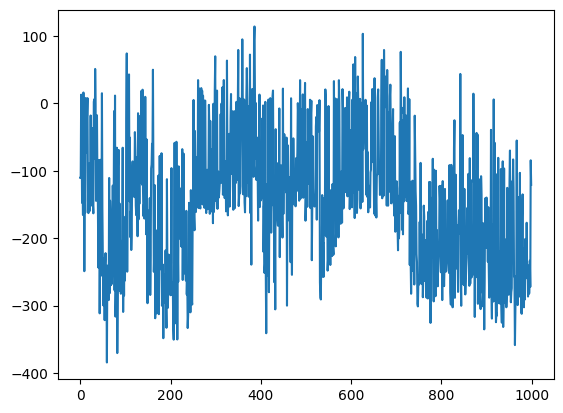

In [161]:
torch.save(lander_steering_actor.state_dict(), "model.pth")
plt.plot(rewards)

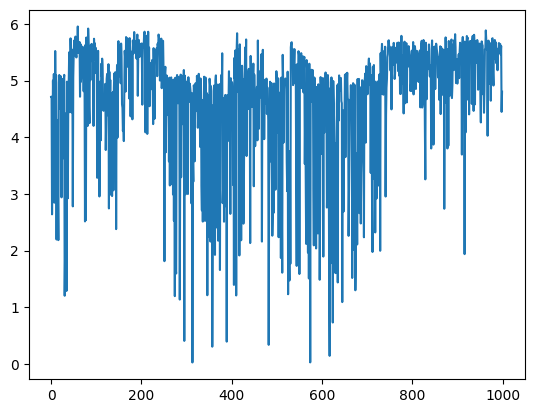

In [162]:
plt.plot([math.log(abs(reward) + 1) for reward in rewards])